In [1]:
import second.builder.anchor_generator_builder as ab
import torch
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load config file
config_path="/home/gx/GitHub/depconv/second/configs/car.fhd.config"
from second.protos import pipeline_pb2
from google.protobuf import text_format
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)

In [3]:
# build network
from second.pytorch.train import build_network
input_cfg = config.train_input_reader
eval_input_cfg = config.eval_input_reader
model_cfg = config.model.second
train_cfg = config.train_config
net = build_network(model_cfg, False)

rpn debug, final_num_filters =  128
rpn debug, num_cls =  2
rpn debug, num_anchor_per_loc =  2


In [4]:
#model_cfg

In [5]:
# builid seperately
from second.builder import target_assigner_builder, voxel_builder
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)

voxel_generator = voxel_builder.build(model_cfg.voxel_generator)
bv_range = voxel_generator.point_cloud_range[[0, 1, 3, 4]]
box_coder = box_coder_builder.build(model_cfg.box_coder)
target_assigner_cfg = model_cfg.target_assigner
target_assigner = target_assigner_builder.build(target_assigner_cfg,
                                                    bv_range, box_coder)
box_coder.custom_ndim = target_assigner._anchor_generators[0].custom_ndim

In [6]:
bv_range

array([  0. , -40. ,  70.4,  40. ], dtype=float32)

In [7]:
# box encode: 
# input box: [N, 7+?] Tensor, xyzwlhr, custom values
# anchors  [N, 7] Tensor, xyzwlhr
# return encoded xyzwlhr

In [8]:
model_cfg.box_coder

ground_box3d_coder {
}

In [9]:
target_assigner_cfg

class_settings {
  anchor_generator_sphere_range {
    sizes: 1.600000023841858
    sizes: 3.9000000953674316
    sizes: 1.559999942779541
    anchor_ranges: 0.0
    anchor_ranges: -40.0
    anchor_ranges: -1.0
    anchor_ranges: 70.4000015258789
    anchor_ranges: 40.0
    anchor_ranges: -1.0
    anchor_sphere_ranges: 0.0
    anchor_sphere_ranges: 70.0
    anchor_sphere_ranges: -0.7853981852531433
    anchor_sphere_ranges: 0.7853981852531433
    rotations: 0.0
    rotations: 1.5700000524520874
  }
  region_similarity_calculator {
    nearest_iou_similarity {
    }
  }
  use_rotate_nms: true
  nms_pre_max_size: 1000
  nms_post_max_size: 100
  nms_score_threshold: 0.30000001192092896
  nms_iou_threshold: 0.009999999776482582
  matched_threshold: 0.5
  unmatched_threshold: 0.30000001192092896
  class_name: "Car"
}
sample_positive_fraction: -1.0
sample_size: 512
assign_per_class: true

In [10]:
grid_size = voxel_generator.grid_size
grid_size

array([512, 512,  64])

In [11]:
from second.utils.config_tool import get_downsample_factor
out_size_factor = get_downsample_factor(model_cfg)
out_size_factor

8

In [12]:
feature_map_size = grid_size[:2] // out_size_factor
feature_map_size

array([64, 64])

In [13]:
feature_map_size = [*feature_map_size, 1][::-1]
feature_map_size  # [1,64,64]

[1, 64, 64]

In [14]:
anchors = target_assigner.generate_anchors(feature_map_size)

feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)


In [15]:
anchors['anchors'].shape
anchors = anchors['anchors']

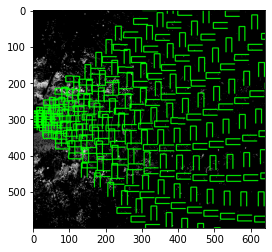

In [16]:

# config_tool.change_detection_range(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
info_path = input_cfg.dataset.kitti_info_path
root_path = Path(input_cfg.dataset.kitti_root_path)
with open(info_path, 'rb') as f:
    infos = pickle.load(f)
    
info = infos[564]
v_path = info["point_cloud"]['velodyne_path']
v_path = str(root_path / v_path)
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 4])



# boxes_lidar = boxes.detach().cpu().numpy()
vis_voxel_size = [0.1, 0.1, 0.1]
# vis_point_range = [-50, -30, -3, 50, 30, 1]
vis_point_range = [0, -40, -3, 80, 40, 1]
# bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
# bev_map = simplevis.draw_box_in_bev(bev_map, vis_point_range, anchors.reshape(-1,7)[::19,:], [0,255,0], 2)

bev_map = simplevis.kitti_vis(points, anchors.reshape(-1,7)[::30,:])
plt.imshow(bev_map)

In [17]:
# generate 64 * 64 *2  anchors
anchors['anchors'][0]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:


from second.core.box_np_ops import create_anchors_3d_sphere_range
create_anchors_3d_sphere_range(feature_map_size, )

In [ ]:
net.rpn

In [ ]:

# r, theta, phi

anchor_ranges = [0, 70] 

In [ ]:

ret = np.meshgrid([1,2],[3,4],[1],[1,2], indexing='ij')

In [ ]:
len(ret)

In [ ]:
ret[0][0][1][0]

In [ ]:
np.array([2,3,4]).shape[0]

In [ ]:
from second.core.box_np_ops import create_anchors_3d_range, create_anchors_3d_sphere_range

In [ ]:
anchors = create_anchors_3d_range([1, 64, 64], [0, -40.0, -1.00, 70.4, 40.0, -1.00])

In [ ]:
anchors[0,1,1,0,0]

In [ ]:
from second.utils import simplevis

In [ ]:
# bev_map = simplevis.kitti_vis([], anchors)
# plt.show(bev_map)

In [ ]:
ret =create_anchors_3d_sphere_range([1,64,64])

In [ ]:
ret.shape

In [ ]:
ret[0,32,31]

In [ ]:
ret[0,33,31]

In [ ]:
ret[0,34,31]

In [ ]:
ret[0,:,:,0,0,0]

In [ ]:
feature_size=[1,64,64]
anchor_range=[0, 70, -0.7853981633974483, +0.7853981633974483]
sizes=[1.6, 3.9, 1.56]
rotations=[0, np.pi / 2]
dtype=np.float32

anchor_range = np.array(anchor_range, dtype)
# r_centers = np.linspace(
#     anchor_range[0], anchor_range[]
# )

r_centers = np.linspace(
    anchor_range[0], anchor_range[1], feature_size[2], dtype=dtype)
phi_centers = np.linspace(
    anchor_range[2], anchor_range[3], feature_size[1], dtype=dtype)

z_centers = np.linspace( -1 , -1, 1, dtype=dtype)
# y_centers = np.linspace(
#     anchor_range[1], anchor_range[4], feature_size[1], dtype=dtype)
# x_centers = np.linspace(
#     anchor_range[0], anchor_range[3], feature_size[2], dtype=dtype)

sizes = np.reshape(np.array(sizes, dtype=dtype), [-1, 3])
rotations = np.array(rotations, dtype=dtype)
rets = np.meshgrid(
    r_centers, phi_centers, z_centers, rotations, indexing='ij')
tile_shape = [1] * 5
tile_shape[-2] = int(sizes.shape[0])
for i in range(len(rets)):
    rets[i] = np.tile(rets[i][..., np.newaxis, :], tile_shape)
    rets[i] = rets[i][..., np.newaxis]  # for concat
sizes = np.reshape(sizes, [1, 1, 1, -1, 1, 3])
tile_size_shape = list(rets[0].shape)
tile_size_shape[3] = 1
sizes = np.tile(sizes, tile_size_shape)
rets.insert(3, sizes)
ret = np.concatenate(rets, axis=-1)
res = np.transpose(ret, [2, 1, 0, 3, 4, 5])


In [ ]:
R = 1.15
r = np.linspace(R,5,3)
theta = np.linspace(0,2*np.pi,4)
len(theta)

In [ ]:
radius_matrix, theta_matrix = np.meshgrid(r,theta, indexing='ij')

In [ ]:
n = np.meshgrid(r,theta, indexing='ij')
n

In [ ]:
radius_matrix

In [ ]:
theta_matrix.shape

In [ ]:
X = radius_matrix * np.cos(theta_matrix)
Y = radius_matrix * np.sin(theta_matrix)

In [ ]:
X

In [ ]:
Y

In [ ]:

ax = plt.subplot(111, polar=True)
ax.plot(theta_matrix, radius_matrix, color='r', ls='none', marker='.')

In [ ]:
plt.plot(X,Y, 'r. ')
plt.show()